# Building a helicopter detector

In [1]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import time
from tqdm import tqdm_notebook
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
from sklearn.model_selection import train_test_split
import numpy as np

#from keras import backend as K
print(tf.__version__)
# create the base pre-trained model
base_model = k.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.summary()

2.0.0-beta1


/home/alex/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

## 1. Transfer learning

In [2]:
# Add the helicopter class
# We will run a helicopter vs non helicopter inference
x = base_model.output
# Add a global_average_pooling2d layer like in the original model
x = GlobalAveragePooling2D()(x)
# and a sigmoid layer -- helicopter or not helicopter
predictions = Dense(2, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNetV2 layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [3]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
# train the model on the new data for a few epochs
# Depending on how long it takes might need the TPU
#model.fit_generator(...)
root = '../0_Database/RPi_import/'
method = 'cropsResizedToNn'
#folder_name = ['190622_201853', '190622_202211', '190624_200747', '190622_234007']
folder_name = ['190622_201853', '190622_202211', '190622_234007']
inputPos = []
inputNeg = []
for folder in folder_name:
    inputPos += [f for f in glob.glob(root+folder+'/'+folder+'_NN_crops/'+method+'/*.jpg')]

for folder in folder_name:
    inputNeg += [f for f in glob.glob(root+folder+'/'+folder+'_NN_crops/Negatives/*.jpg')]
    
print("Detected {} positive images".format(len(inputPos)))
print("Detected {} negative images".format(len(inputNeg)))
X = []
Y = []
print("Loading the positive images...")
for img in tqdm_notebook(inputPos):
    X.append(imread(img))
    Y.append([1, 0])

print("Loading the negative images...")
for img in tqdm_notebook(inputNeg):
    X.append(imread(img))
    Y.append([0, 1])

Detected 2272 positive images
Detected 2272 negative images
Loading the positive images...



Loading the negative images...


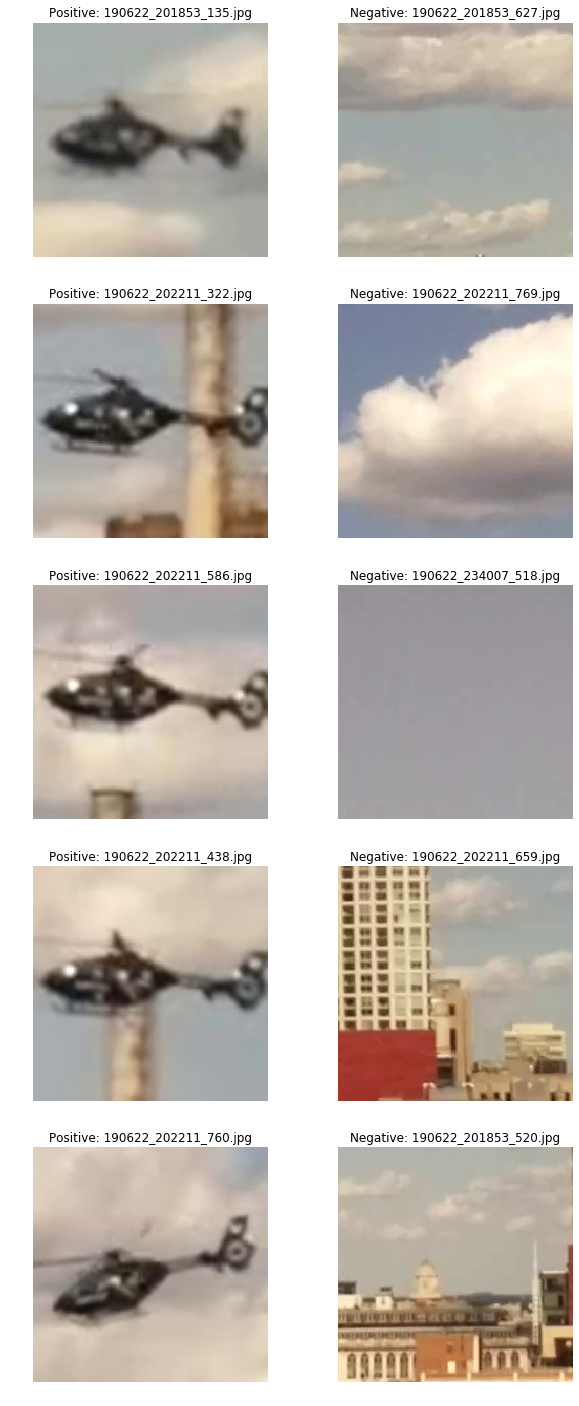

In [25]:
n_col = 5
fig, axes = plt.subplots(n_col, 2, figsize = (10, 5*n_col))
for i in range(n_col):
    index_pos = np.random.randint(len(inputPos))
    index_neg = np.random.randint(len(inputPos), len(inputPos)+len(inputNeg))
    axes[i, 0].imshow(X[index_pos])
    axes[i, 0].set_title("Positive: "+inputPos[index_pos].split('/')[-1])
    axes[i, 0].axis('off')
    axes[i, 1].imshow(X[index_neg])
    axes[i, 1].set_title("Negative: "+inputNeg[index_neg-len(inputPos)].split('/')[-1])
    axes[i, 1].axis('off')

In [17]:
# Transform the list of np array to a 4D matrix
X = np.c_[X]
Y = np.array(Y)
print("X is {}".format(X.shape))
print("Y is {}".format(Y.shape))

# Shuffle the array
trainSplit = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#trainIndexes = np.random.permutation(round(trainSplit*len(X)))
#X_train = X[trainIndexes]
#Y_train = Y[trainIndexes]
print("Train set: {} images\tTest set: {} images".format(len(X_train), len(X_test)))

X is (4544, 224, 224, 3)
Y is (4544, 2)
Train set: 3635 images	Test set: 909 images


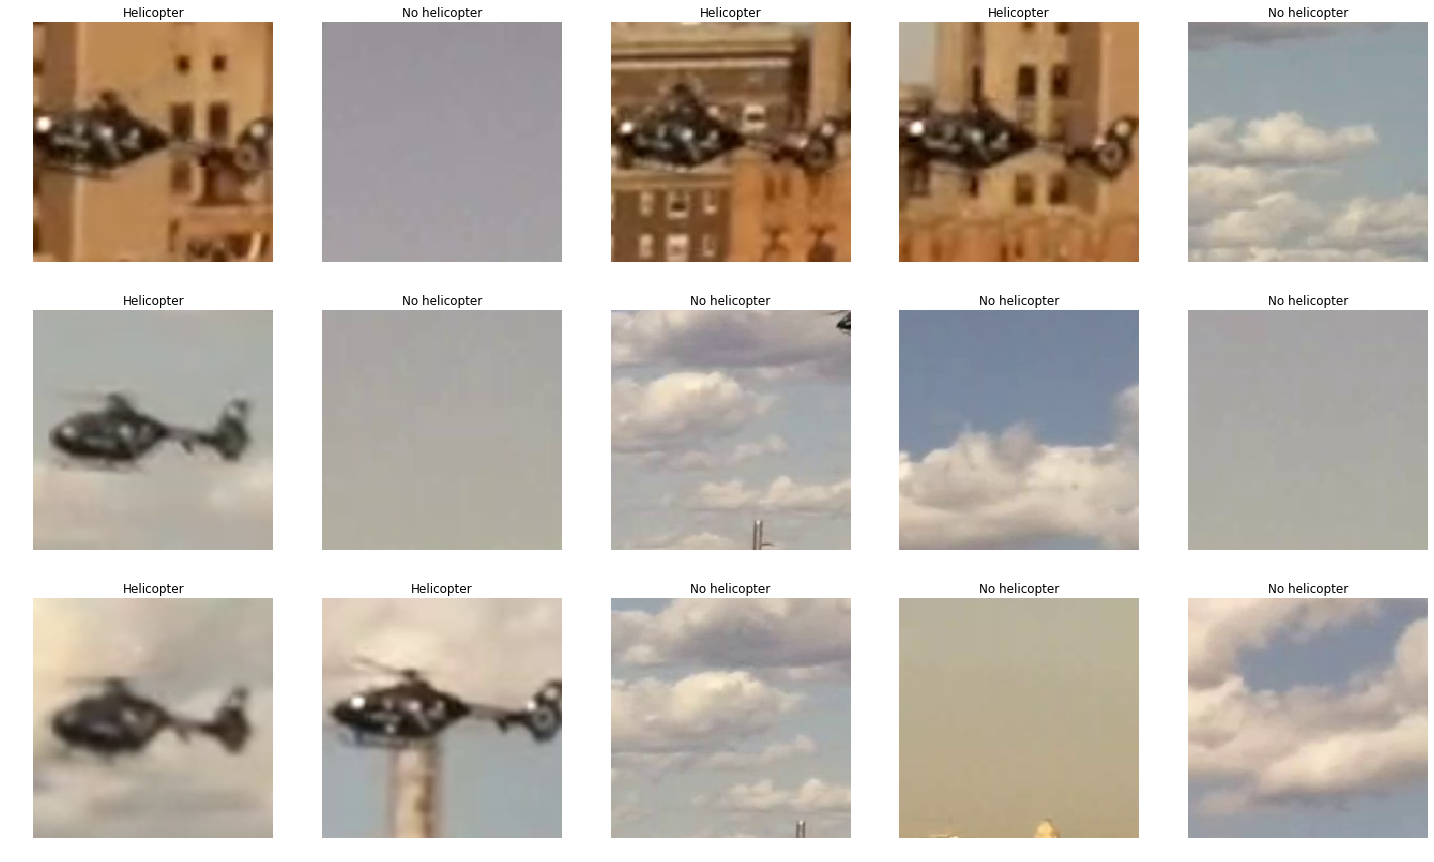

In [47]:
# Display X_train
n_col, n_row = 5, 3
fig, ax = plt.subplots(n_row, n_col, figsize=(5*n_col, 5*n_row))
for i in range(n_row):
    for j in range(n_col):
        index = np.random.randint(len(X_test))
        ax[i, j].imshow(X_train[index])
        ax[i, j].axis('off')
        title = 'Helicopter' if Y_train[index, 0] == 1 else 'No helicopter'
        ax[i, j].set_title(title)

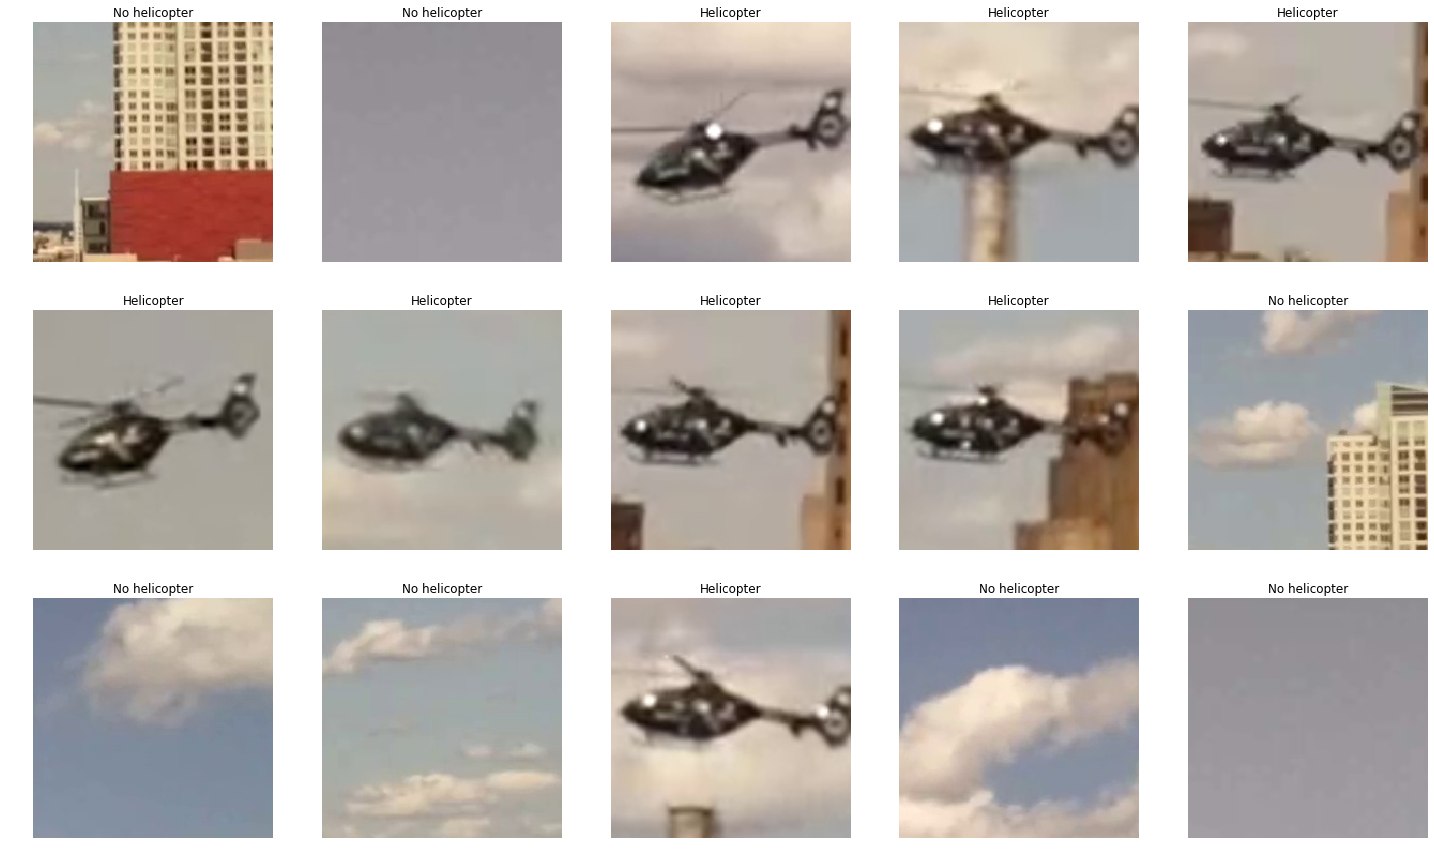

In [48]:
# Display X_test
n_col, n_row = 5, 3
fig, ax = plt.subplots(n_row, n_col, figsize=(5*n_col, 5*n_row))
for i in range(n_row):
    for j in range(n_col):
        index = np.random.randint(len(X_test))
        ax[i, j].imshow(X_test[index])
        ax[i, j].axis('off')
        title = 'Helicopter' if Y_test[index, 0] == 1 else 'No helicopter'
        ax[i, j].set_title(title)

In [49]:
nbEpoch = 5
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
model.fit(X_train, Y_train, validation_split = 0.1, epochs=nbEpoch, callbacks=[es])

Train on 3271 samples, validate on 364 samples
Epoch 1/5
3271/3271 [==============================] - 126s 38ms/sample - loss: 0.0209 - accuracy: 0.9988 - val_loss: 1.0741 - val_accuracy: 0.4258
Epoch 2/5
3271/3271 [==============================] - 132s 40ms/sample - loss: 0.0111 - accuracy: 0.9997 - val_loss: 0.9799 - val_accuracy: 0.3736
Epoch 3/5
3271/3271 [==============================] - 129s 39ms/sample - loss: 0.0112 - accuracy: 0.9997 - val_loss: 1.0997 - val_accuracy: 0.4162
Epoch 4/5
3271/3271 [==============================] - 129s 40ms/sample - loss: 0.0079 - accuracy: 0.9994 - val_loss: 1.0982 - val_accuracy: 0.4066
Epoch 5/5
3271/3271 [==============================] - 129s 39ms/sample - loss: 0.0086 - accuracy: 0.9992 - val_loss: 1.2226 - val_accuracy: 0.4368


In [50]:
modelPred = np.round(model.predict(X_train))
# Train accuracy
accuracy = 1-np.sum(np.abs(Y_train-modelPred), axis=0)[0]/len(X_train)
print("Model accuracy on train set: {:.2f}".format(accuracy))

Model accuracy on train set: 0.43


In [51]:
modelPred = np.round(model.predict(X_test))
# Test accuracy
accuracy = 1-np.sum(np.abs(Y_test-modelPred), axis=0)[0]/len(X_test)
print("Model accuracy on test set: {:.2f}".format(accuracy))

Model accuracy on test set: 0.47


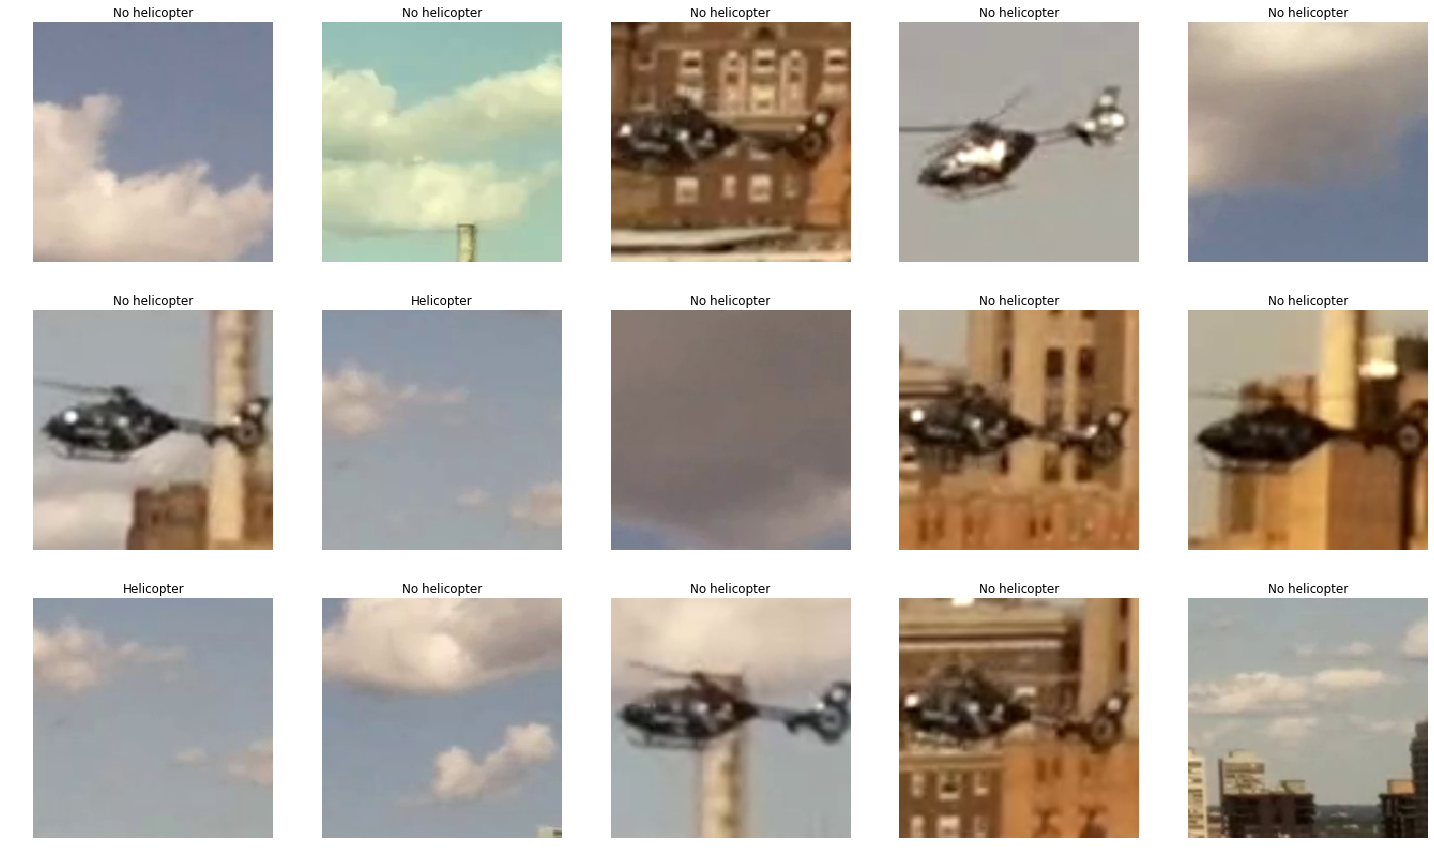

In [52]:
n_col, n_row = 5, 3
fig, ax = plt.subplots(n_row, n_col, figsize=(5*n_col, 5*n_row))
for i in range(n_row):
    for j in range(n_col):
        index = np.random.randint(len(X_test))
        ax[i, j].imshow(X_test[index])
        ax[i, j].axis('off')
        title = 'Helicopter' if modelPred[index, 0] == 1 else 'No helicopter'
        ax[i, j].set_title(title)

(-0.5, 223.5, 223.5, -0.5)

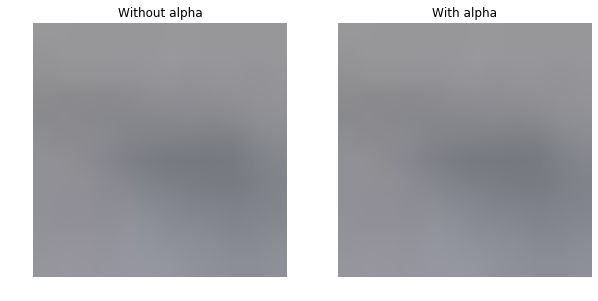

In [8]:
# Is the alpha component really that interesting? No
index = np.random.randint(len(inputPos))
image = imread(inputPos[index])
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image[:, :, :3])
ax[0].set_title("Without alpha")
ax[0].axis("off")
ax[1].imshow(image)
ax[1].set_title("With alpha")
ax[1].axis("off")

## 2. Benchmark result

In [9]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

In [10]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

ModuleNotFoundError: No module named 'keras'